# Biodiversity Challenge Benchmark Notebook                    


## Model Objective

<p align="justify">The objective of this model is to predict the presence of frog species on the basis of TerraClimate variables extracted from the Microsoft Planetary data catalog, which provides data for monthly climate and climatic water balance across global terrestrial surfaces from 1958 to the present.  
</p>

<b>About Notebook: </b><p align="justify"> <p>

<p align="justify">In this notebook, we will demonstrate a basic machine learning workflow, designed to help students gain practical experience with real-world datasets. The focus of this example is to predict presence of frog species using features from the TerraClimate dataset as predictor variables.

To introduce students to satellite data, we have used two features from TerraClimate dataset. For demonstration purpose, a binary model has been prepared using two climate variables only (Vapor Pressure and Downward Shortwave Radiation Flux at the Surface). Students are expected to explore all the climatic variables from TerraClimate dataset to built best possible model using optimum data pre-processing activities.
   
<p align="justify"> The notebook is intended as a learning tool for students to experiment with satellite data and machine learning techniques. While this example makes several simplifying assumptions, students are encouraged to explore further by adjusting the assumptions, experimenting with different approaches, or expanding the dataset to improve results. This flexibility provides an excellent opportunity to deepen understanding through hands-on experimentation.</p>

## To Do Task

Build a Binary Classification model to predict the presence of frog species on the basis of TerraClimate variables extracted from the Microsoft Planetary data catalog, which provides data for monthly climate and climatic water balance across global terrestrial surfaces from 1958 to the present.

For demonstration purpose, a binary model has been prepared using two climate variables only. Students are expected to explore all the climatic variables from TerraClimate dataset to built best possible model using optimum data pre-processing activities.

## Datasets used

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### 1. Frog presence Data
The dataset provides information about the presence of frogs across Australia over a period of 2 years from Nov'2017 to Nov'2019.

Data Source : [Global Biodiversity Information Facility](https://www.gbif.org/) portal.

#### 2.  Climate Data
TerraClimate data from Micorosoft Planetary catalog which provides monthly climate and climatic water balance for global terrestrial surfaces from 1958 to the present. The data provide important inputs for ecological and hydrological studies at global scales that require high spatial resolution and time-varying data.

Data Source : [Terraclimate dataset](https://planetarycomputer.microsoft.com/dataset/terraclimate) from the Microsoft Planetary Computer portal.

<br>
<br>

## Load In Dependencies

To run this demonstration notebook, you will need to have the following packages imported below installed. This may take some time.  

In [1]:
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Data Science
import numpy as np
import pandas as pd

# Multi-dimensional arrays and datasets
import xarray as xr

# Geospatial data analysis
import geopandas as gpd

# Geospatial operations
!pip install rasterio
import rasterio


# Feature Engineering
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# Machine Learning
import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,classification_report,ConfusionMatrixDisplay

# Others
import os
from tqdm import tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 75.5 MB/s eta 0:00:00


## Response Variable

Before building the model, we need to load the frog presence dataset. We have curated data for the southeastern region of Australia. The dataset consists of geolocations (Latitude and Longitude), with an additional field for Occurrence Status.

In [2]:
# Load the training data from csv file and display the first few rows to inspect the data
ground_df = pd.read_csv("/content/Training_Data.csv")
ground_df.head()

,Latitude,Longitude,Occurrence Status
0,-34.027900,150.771000,1
1,-34.821595,147.193697,1
2,-36.617759,146.882941,0
3,-37.470900,144.744000,1
4,-38.400153,145.018560,1


Here 1 indicate the frog presence and 0 indicate the non-presence of the frog at the given location.

In [3]:
#Check dataframe shape.
ground_df.shape

(6312, 3)

## Predictor Variables

<p align="justify">Now that we have our frog presence data, it is time to gather the predictor variables from the TerraClimate dataset. Students should review the provided TerraClimate sample notebook, as it was used to create a sample GeoTIFF for this model. For a more in-depth look at the TerraClimate dataset and how to query it, see the Microsoft Planetary Computer example <a href="https://planetarycomputer.microsoft.com/dataset/terraclimate#Example-Notebook">TerraClimate supplementary notebook</a>.</p> <p align="justify">The TerraClimate dataset provides high-resolution climate data that is crucial for understanding ecological patterns. Variables such as srad (Downward Shortwave Radiation Flux at the Surface) and vap (vapor pressure) help in predicting frog presence and absence. Hence, we are choosing srad and vap as predictor variables for this experiment.</p> <ul> <li>srad - Downward Shortwave Radiation Flux at the Surface, which helps in understanding the amount of energy received at the Earth's surface, influencing climate conditions and vegetation growth.</li> <li>vap - Vapor pressure data, which provides information on humidity levels and water availability, important for understanding frog habitats.</li> </ul>

<h4 style="color:rgb(255, 255, 0)"><strong>Tip 1</strong></h4> <p align="justify">Stidents might explore other climatic variables from the TerraClimate dataset and other climate or environmental datasets as well. These variables may provide insights into climate conditions, humidity levels, or environmental factors that could influence frog presence and absence patterns.</p>

### Analyze the TerraClimate Data

<p align="justify">To obtain the TerraClimate data, we created a GeoTIFF image for the southeastern region of Australia, covering the two-year period from November 1, 2017, to November 1, 2019. The final GeoTIFF contains two variables: srad (Downward Shortwave Radiation Flux at the Surface) and vap (vapor pressure), with each variable representing the median of values for the given time period. Students should refer to the provided TerraClimate sample notebook for output images and further details on modifying the data.</p>

### Methods of Extracting Variables from TerraClimate Data Catalog
There are two common methods to extract variables from TerraClimate data catalog:

<ul> <li><strong>Using API Calls:</strong> Retrieve variables directly from TerraClimate datasets via APIs, such as the <code>planetary_computer</code>.</li> </ul> <ul> <li><strong>Using GeoTIFF Images:</strong> Create and download a GeoTIFF image containing the desired variables and extract the values locally. The GeoTIFF image can represent any desired time period (such as a single date or a time series mosaic) and include any number of climate variables.</li> </ul>

Students can choose either of these approaches based on their convenience. Since our dataset is large, the API method can be time-consuming and resource-intensive. Therefore, in this sample notebook, we have opted for the second method and extracted the values for variables srad (Downward Shortwave Radiation Flux at the Surface) and vap (vapor pressure). Please refer to the TerraClimate sample notebook for details about the creation of the GeoTIFF image.

### Downloading GeoTIFF Image

For building a sample model in this demonstration notebook, we have downloaded a GeoTIFF file locally for the two-year period (from November 1, 2017, to November 1, 2019). The file is named <b>TerraClimate_GeoTiff.tiff</b>. This GeoTIFF file contains values for two variables: srad (Downward Shortwave Radiation Flux at the Surface) and vap (vapor pressure). In the subsequent section, we will use this GeoTIFF file to extract the variable values for the geo-locations provided in the training dataset to create the features.

First, let’s visualize the variables in the downloaded GeoTIFF image.

In [4]:
tiff_path = "/content/TerraClimate_output (1).ipynb"
print(os.path.exists(tiff_path))

False


In [5]:
# Verfying the tiff file and checking the existance of all bands

tiff_path = "/content/TerraClimate_output (1).tiff"

try:
    with rasterio.open(tiff_path) as dataset:
        band_count = dataset.count  # Number of bands in the TIFF file
        metadata = dataset.meta  # Metadata about the dataset
        field_names = dataset.descriptions  # Band descriptions

        # If band descriptions are not present, generate placeholders
        if not any(field_names):
            field_names = [f"Band {i+1}" for i in range(band_count)]

except Exception as e:
    field_names = f"Error reading TIFF file: {e}"

field_names


['Band 1',
 'Band 2',
 'Band 3',
 'Band 4',
 'Band 5',
 'Band 6',
 'Band 7',
 'Band 8',
 'Band 9',
 'Band 10',
 'Band 11',
 'Band 12',
 'Band 13',
 'Band 14']

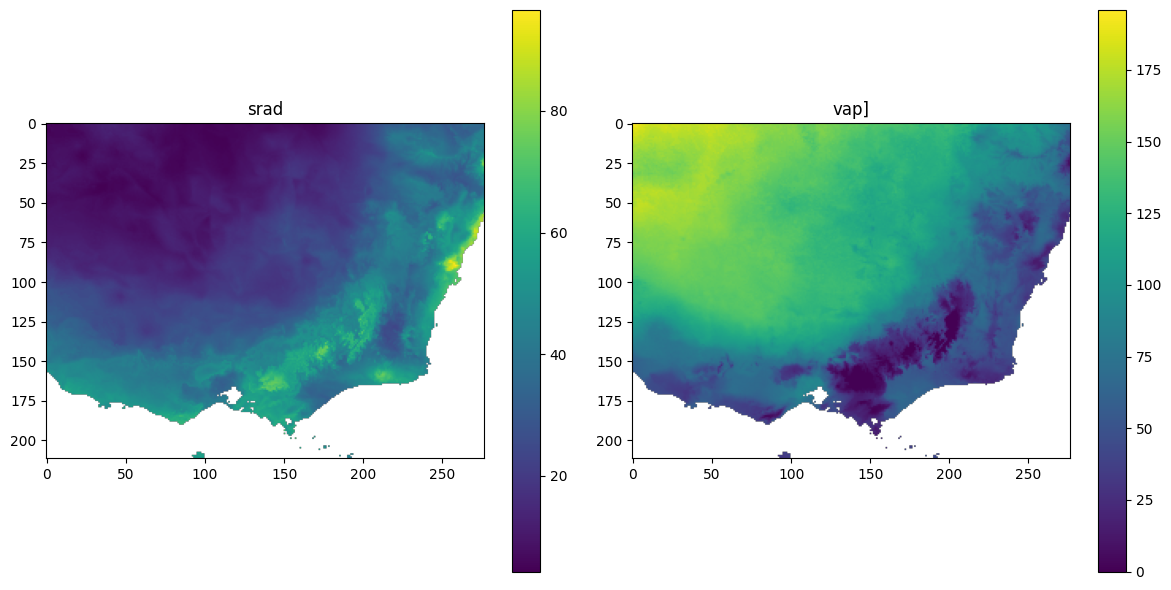

In [6]:
# Reads and plots two climatic parameters srad and vap from the GeoTIFF file.

tiff_path = "/content/TerraClimate_output (1).tiff"

with rasterio.open(tiff_path) as src1:
    variable1 = src1.read(1)
    variable2 = src1.read(2)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes = axes.flatten()

im1 = axes[0].imshow(variable1, cmap='viridis')
axes[0].set_title('srad')
fig.colorbar(im1, ax=axes[0])

im2 = axes[1].imshow(variable2, cmap='viridis')
axes[1].set_title('vap]')
fig.colorbar(im2, ax=axes[1])

plt.tight_layout()
plt.show()


### Extracting Climatic variables from the TerraClimate sample GeoTiff image

In [7]:

def map_satellite_data(tiff_path, csv_path):
    """
    Extracts all climate variables from a GeoTIFF file based on latitude and longitude coordinates from a CSV file,
    ensuring each band retains its correct variable name.
    """

    df = pd.read_csv(csv_path)

    # Open the GeoTIFF file and extract band names
    with rasterio.open(tiff_path) as dataset:
        num_bands = dataset.count  # Total bands in TIFF
        band_descriptions = dataset.descriptions

        if not any(band_descriptions):
            band_descriptions = ["aet", "def", "pdsi", "pet", "ppt", "q", "soil",
                                 "srad", "swe", "tmax", "tmin", "vap", "vpd", "ws"]

        # Ensure the number of bands matches the number of variable names
        if len(band_descriptions) != num_bands:
            raise ValueError(f"Mismatch: Found {num_bands} bands but {len(band_descriptions)} variable names!")

        print("Using Band Descriptions:", band_descriptions)

        extracted_values = {var_name: [] for var_name in band_descriptions}

        for _, row in tqdm(df.iterrows(), total=df.shape[0], desc="Extracting raster values"):
            target_lat, target_lon = row["Latitude"], row["Longitude"]

            row_idx, col_idx = dataset.index(target_lon, target_lat)

            if row_idx < 0 or row_idx >= dataset.height or col_idx < 0 or col_idx >= dataset.width:
                for var_name in band_descriptions:
                    extracted_values[var_name].append(np.nan)
                continue

            for band_idx, var_name in enumerate(band_descriptions, start=1):
                extracted_values[var_name].append(dataset.read(band_idx)[row_idx, col_idx])

    df_extracted = pd.DataFrame(extracted_values)

    return df_extracted

In [8]:
import rasterio

file_path = "TerraClimate_output (1).tiff"

with rasterio.open(file_path) as dataset:
    print("Number of bands available:", dataset.count)


Number of bands available: 14


In [9]:
final_data = map_satellite_data('TerraClimate_output (1).tiff', 'Training_Data.csv')

Using Band Descriptions: ['aet', 'def', 'pdsi', 'pet', 'ppt', 'q', 'soil', 'srad', 'swe', 'tmax', 'tmin', 'vap', 'vpd', 'ws']


Extracting raster values: 100%|██████████| 6312/6312 [00:18<00:00, 342.62it/s]


In [11]:
final_data.head(5)

,aet,def,pdsi,pet,ppt,q,soil,srad,swe,tmax,tmin,vap,vpd,ws
0,53.500000,65.300003,-4.5,115.500000,49.7,2.5,16.700001,200.799149,0.0,23.900000,12.599999,1.233,0.81,3.6
1,24.800001,110.800003,-3.9,143.100006,26.0,1.3,2.500000,217.699799,0.0,24.400000,10.700000,0.938,1.28,3.1
2,51.299999,28.200001,-3.8,115.099998,69.9,3.5,68.800003,204.000031,0.0,21.400000,8.099999,0.942,0.78,3.2
3,41.000000,67.300003,-4.7,120.700005,45.0,2.3,11.300000,204.400146,0.0,20.199999,8.000000,0.951,0.70,4.4
4,58.900002,29.500000,-4.8,109.500000,71.1,3.6,43.000000,189.203964,0.0,18.900000,9.900000,1.096,0.50,5.6


In [12]:
final_data

,aet,def,pdsi,pet,ppt,q,soil,srad,swe,tmax,tmin,vap,vpd,ws
0,53.500000,65.300003,-4.5,115.500000,49.7,2.5,16.700001,200.799149,0.0,23.900000,12.599999,1.233,0.81,3.6
1,24.800001,110.800003,-3.9,143.100006,26.0,1.3,2.500000,217.699799,0.0,24.400000,10.700000,0.938,1.28,3.1
2,51.299999,28.200001,-3.8,115.099998,69.9,3.5,68.800003,204.000031,0.0,21.400000,8.099999,0.942,0.78,3.2
3,41.000000,67.300003,-4.7,120.700005,45.0,2.3,11.300000,204.400146,0.0,20.199999,8.000000,0.951,0.70,4.4
4,58.900002,29.500000,-4.8,109.500000,71.1,3.6,43.000000,189.203964,0.0,18.900000,9.900000,1.096,0.50,5.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6307,51.400002,65.400002,-4.5,118.099998,50.9,2.5,15.200000,201.799423,0.0,24.100000,13.099999,1.263,0.81,3.7
6308,30.500000,90.800003,-2.6,127.800003,28.0,1.4,8.200000,212.802444,0.0,22.000000,7.900000,0.998,0.92,3.8
6309,36.799999,60.799999,-4.8,121.700005,38.0,1.9,5.900000,189.700104,0.0,21.500000,9.900000,1.106,0.61,4.7
6310,40.600002,47.100002,-3.8,111.200005,49.8,2.5,26.200001,200.999207,0.0,18.600000,7.100000,0.941,0.58,4.4


## Joining the predictor variables and response variables
Now that we have extracted our predictor variables, we need to join them onto the response variable . We use the function <i><b>combine_two_datasets</b></i> to combine the predictor variables and response variables.The <i><b>concat</b></i> function from pandas comes in handy here.

In [13]:
# Combine two datasets vertically (along columns) using pandas concat function.

def combine_two_datasets(dataset1,dataset2):
    '''
    Returns a  vertically concatenated dataset.
    Attributes:
    dataset1 - Dataset 1 to be combined
    dataset2 - Dataset 2 to be combined
    '''

    data = pd.concat([dataset1,dataset2], axis=1)
    return data

In [14]:
final_data = combine_two_datasets(ground_df,final_data)
final_data.head()

,Latitude,Longitude,Occurrence Status,aet,def,pdsi,pet,ppt,q,soil,srad,swe,tmax,tmin,vap,vpd,ws
0,-34.027900,150.771000,1,53.500000,65.300003,-4.5,115.500000,49.7,2.5,16.700001,200.799149,0.0,23.900000,12.599999,1.233,0.81,3.6
1,-34.821595,147.193697,1,24.800001,110.800003,-3.9,143.100006,26.0,1.3,2.500000,217.699799,0.0,24.400000,10.700000,0.938,1.28,3.1
2,-36.617759,146.882941,0,51.299999,28.200001,-3.8,115.099998,69.9,3.5,68.800003,204.000031,0.0,21.400000,8.099999,0.942,0.78,3.2
3,-37.470900,144.744000,1,41.000000,67.300003,-4.7,120.700005,45.0,2.3,11.300000,204.400146,0.0,20.199999,8.000000,0.951,0.70,4.4
4,-38.400153,145.018560,1,58.900002,29.500000,-4.8,109.500000,71.1,3.6,43.000000,189.203964,0.0,18.900000,9.900000,1.096,0.50,5.6


## Removing duplicates
Identical or duplicate entries are removed based on specific columns, in our case [ 'srad', 'vap']. This ensures that the dataset is not biased or skewed by repetitive data, allowing the model to train on unique, relevant observations.

In [15]:
# columns_to_check = ['srad', 'vap', 'Occurrence Status']
# for col in columns_to_check:
#     # Check if the value is a numpy array and has more than one dimension
#     final_data[col] = final_data[col].apply(lambda x: x.item() if isinstance(x, np.ndarray) and x.ndim == 0 else x)

# final_data = final_data.drop_duplicates(subset=columns_to_check, keep='first')
# final_data.shape


In [16]:
final_data=final_data.reset_index(drop=True)

In [17]:
final_data.head()

,Latitude,Longitude,Occurrence Status,aet,def,pdsi,pet,ppt,q,soil,srad,swe,tmax,tmin,vap,vpd,ws
0,-34.027900,150.771000,1,53.500000,65.300003,-4.5,115.500000,49.7,2.5,16.700001,200.799149,0.0,23.900000,12.599999,1.233,0.81,3.6
1,-34.821595,147.193697,1,24.800001,110.800003,-3.9,143.100006,26.0,1.3,2.500000,217.699799,0.0,24.400000,10.700000,0.938,1.28,3.1
2,-36.617759,146.882941,0,51.299999,28.200001,-3.8,115.099998,69.9,3.5,68.800003,204.000031,0.0,21.400000,8.099999,0.942,0.78,3.2
3,-37.470900,144.744000,1,41.000000,67.300003,-4.7,120.700005,45.0,2.3,11.300000,204.400146,0.0,20.199999,8.000000,0.951,0.70,4.4
4,-38.400153,145.018560,1,58.900002,29.500000,-4.8,109.500000,71.1,3.6,43.000000,189.203964,0.0,18.900000,9.900000,1.096,0.50,5.6


<p align="justify"> Now let us select the columns required for our model building exercise. We will consider only srad and vap from the final data as our predictor variables. It does not make sense to use latitude and longitude as predictor variables, as they do not have any direct impact on predicting the presence of frog.</p>

In [18]:
# Retaining only the columns for srad, vap and Occurrence Status in the dataset

final_data=final_data[["aet", "def",	"pdsi",	"pet",	"ppt",	"soil"	,"srad",	"swe",	"tmax"	,"tmin",	"vap"	,"vpd",	"ws",'Occurrence Status']]


In [19]:
model_data = final_data.copy()

The `describe()` function summarizes key statistics of the dataset, helping to understand its distribution, detect potential issues, and assess whether preprocessing steps like scaling or handling imbalances are needed before model training.

In [20]:
model_data.describe()

,aet,def,pdsi,pet,ppt,soil,srad,swe,tmax,tmin,vap,vpd,ws,Occurrence Status
count,6295.000000,6295.000000,6295.000000,6295.000000,6295.00000,6295.000000,6295.000000,6295.000000,6295.000000,6295.000000,6295.000000,6295.000000,6295.000000,6312.000000
mean,42.562050,66.800907,-4.208181,120.977317,47.13892,22.625815,205.962989,0.000032,21.774440,9.308880,1.014216,0.822578,3.885449,0.600760
std,14.400684,35.622848,0.782806,16.699602,18.61633,30.881096,12.178299,0.001782,2.715623,2.276535,0.136297,0.331569,0.782649,0.489781
min,9.600000,0.000000,-6.500000,82.700005,10.10000,0.300000,177.896866,0.000000,10.599999,1.100000,0.581000,0.300000,2.600000,0.000000
25%,33.200001,40.299999,-4.700000,109.000000,34.10000,3.100000,197.302185,0.000000,19.799999,7.700000,0.938000,0.580000,3.200000,0.000000
50%,42.600002,61.299999,-4.400000,116.200005,45.10000,12.000000,204.000031,0.000000,21.299999,9.200000,0.983000,0.700000,3.700000,1.000000
75%,51.900002,90.400002,-3.800000,130.199997,59.10000,28.800001,215.200500,0.000000,23.699999,10.800000,1.064000,0.980000,4.300000,1.000000
max,96.599998,149.199997,-2.300000,164.800003,127.80000,219.699997,236.897064,0.100000,28.199999,15.200000,1.469000,1.750000,7.050000,1.000000


In [21]:
# Count NaN values in each column
nan_counts = model_data.isna().sum()

# Display NaN count per column
print(nan_counts)

# Remove rows with NaN values
model_data = model_data.dropna()

# Count NaN values in each column
nan_counts = model_data.isna().sum()

print(nan_counts)


aet                  17
def                  17
pdsi                 17
pet                  17
ppt                  17
soil                 17
srad                 17
swe                  17
tmax                 17
tmin                 17
vap                  17
vpd                  17
ws                   17
Occurrence Status     0
dtype: int64
aet                  0
def                  0
pdsi                 0
pet                  0
ppt                  0
soil                 0
srad                 0
swe                  0
tmax                 0
tmin                 0
vap                  0
vpd                  0
ws                   0
Occurrence Status    0
dtype: int64


In [22]:
# Define features and target.
x = model_data.iloc[:,0:-1]
y = model_data["Occurrence Status"].values

#from imblearn.over_sampling import SMOTE
#smote = SMOTE(sampling_strategy='auto', random_state=42)
#x, y = smote.fit_resample(model_data.iloc[:, :-1], model_data.iloc[:, -1])


### Building and Training the Machine Learning Pipeline

In this section, we define a machine learning pipeline that includes both preprocessing and model training steps. First, we specify the numerical features (`srad` and `vap`) and set up a preprocessing pipeline (`num_transformer`). This pipeline applies a `SimpleImputer` to handle any missing values by replacing them with the median, followed by a `MinMaxScaler` to normalize the data. Then, we combine this preprocessing step using `ColumnTransformer`. Next, we define a Logistic Regression model, which will be trained on the processed data. The entire workflow, including preprocessing and model fitting, is encapsulated in a `Pipeline`. We then split the dataset into training and test sets, using 70% of the data for training and 30% for testing. Finally, we train the pipeline using the training data. This ensures that preprocessing and model fitting occur in a streamlined and consistent manner.

In [23]:

from sklearn.ensemble import RandomForestClassifier
features = ["aet", "def",	"pdsi",	"pet",	"ppt",	"soil"	,"srad",	"swe",	"tmax"	,"tmin",	"vap"	,"vpd",	"ws"]

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, stratify=y, random_state=42)
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

feature_importance = pd.Series(rf.feature_importances_, index=features)
print(feature_importance.sort_values(ascending=False))

ppt     0.109476
aet     0.106565
srad    0.096719
pet     0.094079
def     0.092141
vap     0.090322
pdsi    0.076827
soil    0.073125
tmin    0.070264
vpd     0.067459
tmax    0.063815
ws      0.059208
swe     0.000000
dtype: float64


In [48]:
#features = ["aet", "def",	"pdsi",	"pet",	"ppt",	"soil"	,"srad",	"swe",	"tmax"	,"tmin",	"vap"	,"vpd",	"ws"]
#features = ["srad", "vap"]
#features = ["ppt", "aet", "srad", "pet", "def", "vap", "pdsi", "soil", "tmin", "vpd", "tmax"]
features = ["ppt", "aet", "srad", "pet", "def", "vap","pdsi"]

# Define preprocessing steps
transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", MinMaxScaler())
])

# Combine transformers using ColumnTransformer
preprocessor = ColumnTransformer([
    ("num", transformer, features)
])

# Define the Logistic Regression model
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, max_depth=50, random_state=42)

# Create the full pipeline
pipeline = Pipeline([
    ("preprocessing", preprocessor),
    ("classifier", model)
])

# Split dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, stratify=y, random_state=42)

pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['ppt', 'aet', 'srad', 'pet',
                                                   'def', 'vap', 'pdsi'])])),
                ('classifier',
                 RandomForestClassifier(max_depth=50, random_state=42))])

In [49]:
joblib.dump(pipeline, "regression_pipeline.pkl")
print("Pipeline saved successfully!")

Pipeline saved successfully!


In [53]:
from google.colab import files
files.download("/content/regression_pipeline.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [54]:
save_path = "/content/drive/MyDrive//final_pipeline_model.pkl"



In [55]:
# import joblib

# joblib.dump(pipeline, save_path)
# print(f"Pipeline saved successfully to {save_path}")


## Model Evaluation

<p align="justify">Now that we have trained our model, the next step is to evaluate its performance. For evaluation, we will use the classification report, which provides key metrics like precision, recall, F1-score, and accuracy for each class. These metrics help assess how well the model is predicting frog presence and absence (Occurrence Status). Scikit-learn's `classification_report` function will give us a detailed summary of the model's performance, which can be useful for understanding its strengths and weaknesses. You can also use other metrics or customize the evaluation as needed.</p>

### In-Sample Evaluation
<p align="justify">We will be evaluating our model's performance using the classification report on the training data. It is important to note that this is in-sample performance testing, which involves evaluating the model on the training dataset. These metrics, such as precision, recall, F1-score, and accuracy, are not truly indicative of the model's ability to generalize. You should reserve testing on the test data before drawing final conclusions about your model's performance.</p>

<p align="justify">In this section, we make predictions on the training set and store them in the <b><i>insample_predictions</i></b> variable. The classification report is then calculated to evaluate the model's performance on the training data, providing metrics like precision, recall, F1-score, and accuracy. It is important to keep in mind that this evaluation is for the training set, and further testing on the test set is necessary to assess the model's generalizability.</p>

In [56]:
# Make predictions on the training data
insample_predictions = pipeline.predict(X_train)
print(classification_report(y_train,insample_predictions))

              precision    recall  f1-score   support

           0       0.98      0.95      0.97      1763
           1       0.97      0.99      0.98      2643

    accuracy                           0.97      4406
   macro avg       0.98      0.97      0.97      4406
weighted avg       0.97      0.97      0.97      4406



### Confusion matrix of train data

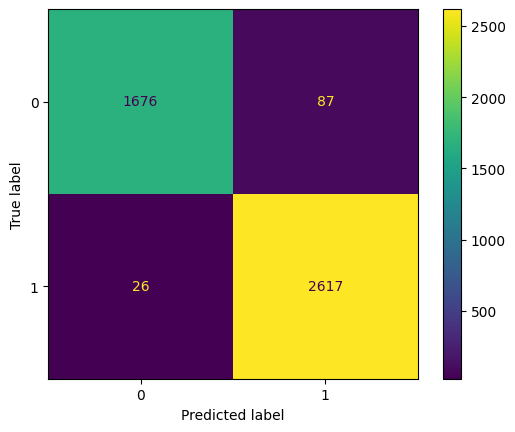

In [46]:
# Display confusion matrix.
ConfusionMatrixDisplay(confusion_matrix(y_train,insample_predictions)).plot()

### Out-Sample Evaluation

<p align="justify">When evaluating a machine learning model, it is crucial to assess its ability to generalize accurately. This is because models often tend to overfit the data they are trained on. To estimate the model's out-of-sample performance, we will now make predictions on the test data.</p>

In [28]:
# Make predictions and evaluate performance
outsample_predictions=pipeline.predict(X_test)
print(classification_report(y_test,outsample_predictions))

              precision    recall  f1-score   support

           0       0.70      0.65      0.67       756
           1       0.78      0.82      0.80      1133

    accuracy                           0.75      1889
   macro avg       0.74      0.73      0.73      1889
weighted avg       0.75      0.75      0.75      1889



### Confusion matrix of test data

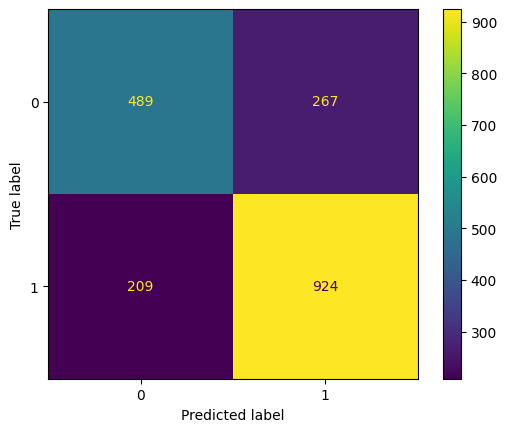

In [29]:
# Display confusion matrix.
ConfusionMatrixDisplay(confusion_matrix(y_test,outsample_predictions)).plot()

## Model Validation on a New Location

<p align="justify">Once you are satisfied with your model, you can validate the model on the dataset of a different location. To do this, use your model to predict the frog occurrence status for a set of test coordinates provided in the <b>"Validation_template.csv"</b> file and share the predicted results to the instructor/professor.</p>

In [30]:
#Reading the coordinates for the validation dataset
test_file = pd.read_csv('/content/Validation_Template.csv')
test_file.head()

,Latitude,Longitude
0,-33.121788,150.320746
1,-36.592011,148.172262
2,-35.455100,146.693465
3,-33.076261,149.547177
4,-35.529729,146.627272


In [31]:
# check dataframe shape
test_file.shape

(2000, 2)

In [32]:
# Mapping satellite data with test data.
final_val_data = map_satellite_data('TerraClimate_output (1).tiff', 'Validation_Template.csv')

Using Band Descriptions: ['aet', 'def', 'pdsi', 'pet', 'ppt', 'q', 'soil', 'srad', 'swe', 'tmax', 'tmin', 'vap', 'vpd', 'ws']


Extracting raster values: 100%|██████████| 2000/2000 [00:05<00:00, 334.91it/s]


In [33]:
final_val_data.head()

,aet,def,pdsi,pet,ppt,q,soil,srad,swe,tmax,tmin,vap,vpd,ws
0,38.400002,52.700001,-4.6,106.000000,39.4,2.0,10.900001,205.896545,0.0,21.500000,9.300000,1.020,0.73,2.8
1,48.799999,23.500000,-4.8,108.200005,62.6,3.1,29.300001,197.801514,0.0,18.500000,5.000000,0.827,0.53,3.7
2,25.100000,114.500000,-4.4,139.199997,25.4,1.3,2.900000,221.500839,0.0,24.199999,10.599999,0.964,1.16,3.2
3,36.400002,71.500000,-3.9,121.800003,38.1,1.9,4.300000,220.403244,0.0,22.400000,8.599999,1.008,0.93,3.2
4,24.700001,113.500000,-4.4,138.100006,25.5,1.3,2.900000,221.700897,0.0,24.100000,10.400000,0.964,1.16,3.2


In [34]:
# Loading the trained model and predict on validation data.
loaded_pipeline = joblib.load("regression_pipeline.pkl")
final_predictions = loaded_pipeline.predict(final_val_data)
final_prediction_series = pd.Series(final_predictions)

In [35]:
#Combining the results into dataframe
submission_df = pd.DataFrame({'Latitude':test_file['Latitude'].values, 'Longitude':test_file['Longitude'].values,  'Occurrence Status':final_prediction_series.values})

In [36]:
#Displaying the dataframe
display(submission_df)

,Latitude,Longitude,Occurrence Status
0,-33.121788,150.320746,1
1,-36.592011,148.172262,0
2,-35.455100,146.693465,0
3,-33.076261,149.547177,1
4,-35.529729,146.627272,0
...,...,...,...
1995,-33.342761,145.736478,0
1996,-34.455690,150.442003,1
1997,-36.241444,144.720379,1
1998,-32.194000,148.900320,1


In [37]:
#Dumping the predictions into a csv file.
submission_df.to_csv("Predicted_Data.csv",index = False)

## Conclusion

Having explored and implemented a baseline modeling pipeline, we have now developed and finalized our custom approach to the frog presence prediction task. This notebook reflects our enhanced workflow, including feature selection, preprocessing, model training, and evaluation.

The final model has been trained using selected climate variables, with careful attention to data handling, feature engineering, and classifier optimization.

The resulting predictions are saved in the file Predicted_Dataset.csv. This file is intended for submission and evaluation by the instructor.